In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_noise.explorer import (SpikeTrainExplorer,
                                   RecordingExplorer)
from neural_noise import config


import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

In [3]:
logging.basicConfig(level=logging.ERROR)

# Loading configuration files and YASS output

YASS is a Python package for spike sorting, which is being developed by Peter Lee (PhD in the Stats department and me): https://github.com/paninski-lab/yass

Someone in the lab implemented a truncated DPMM using numpy. Since the code is hard to debug and the only person who understands it is the person who wrote it, I want to see if we can start using Edward instead, so we can iterate quickly and prototype new models easily – without having to write custom inference algorithms every time.


In [4]:
# load configuration files
cfg_yass = Config.from_yaml('../yass_config/local_100k.yaml')
cfg = config.load('../config.yaml')

In [5]:
# load data generated from yass
files = ['score', 'clear_index', 'spike_times', 'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

# Loading raw recordings, geometry file and projection matrix

In [96]:
# load raw recordings
path_to_raw_recordings = os.path.join(cfg_yass.root, 'sample_100k.bin')
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [7]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

# Initialize explorers

In [97]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_raw = RecordingExplorer(path_to_raw_recordings,
                                 path_to_geometry,
                                 dtype='int16',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)


explorer_train = SpikeTrainExplorer(templates,
                                    spike_train,
                                    explorer_rec,
                                    proj)

# Raw recordings

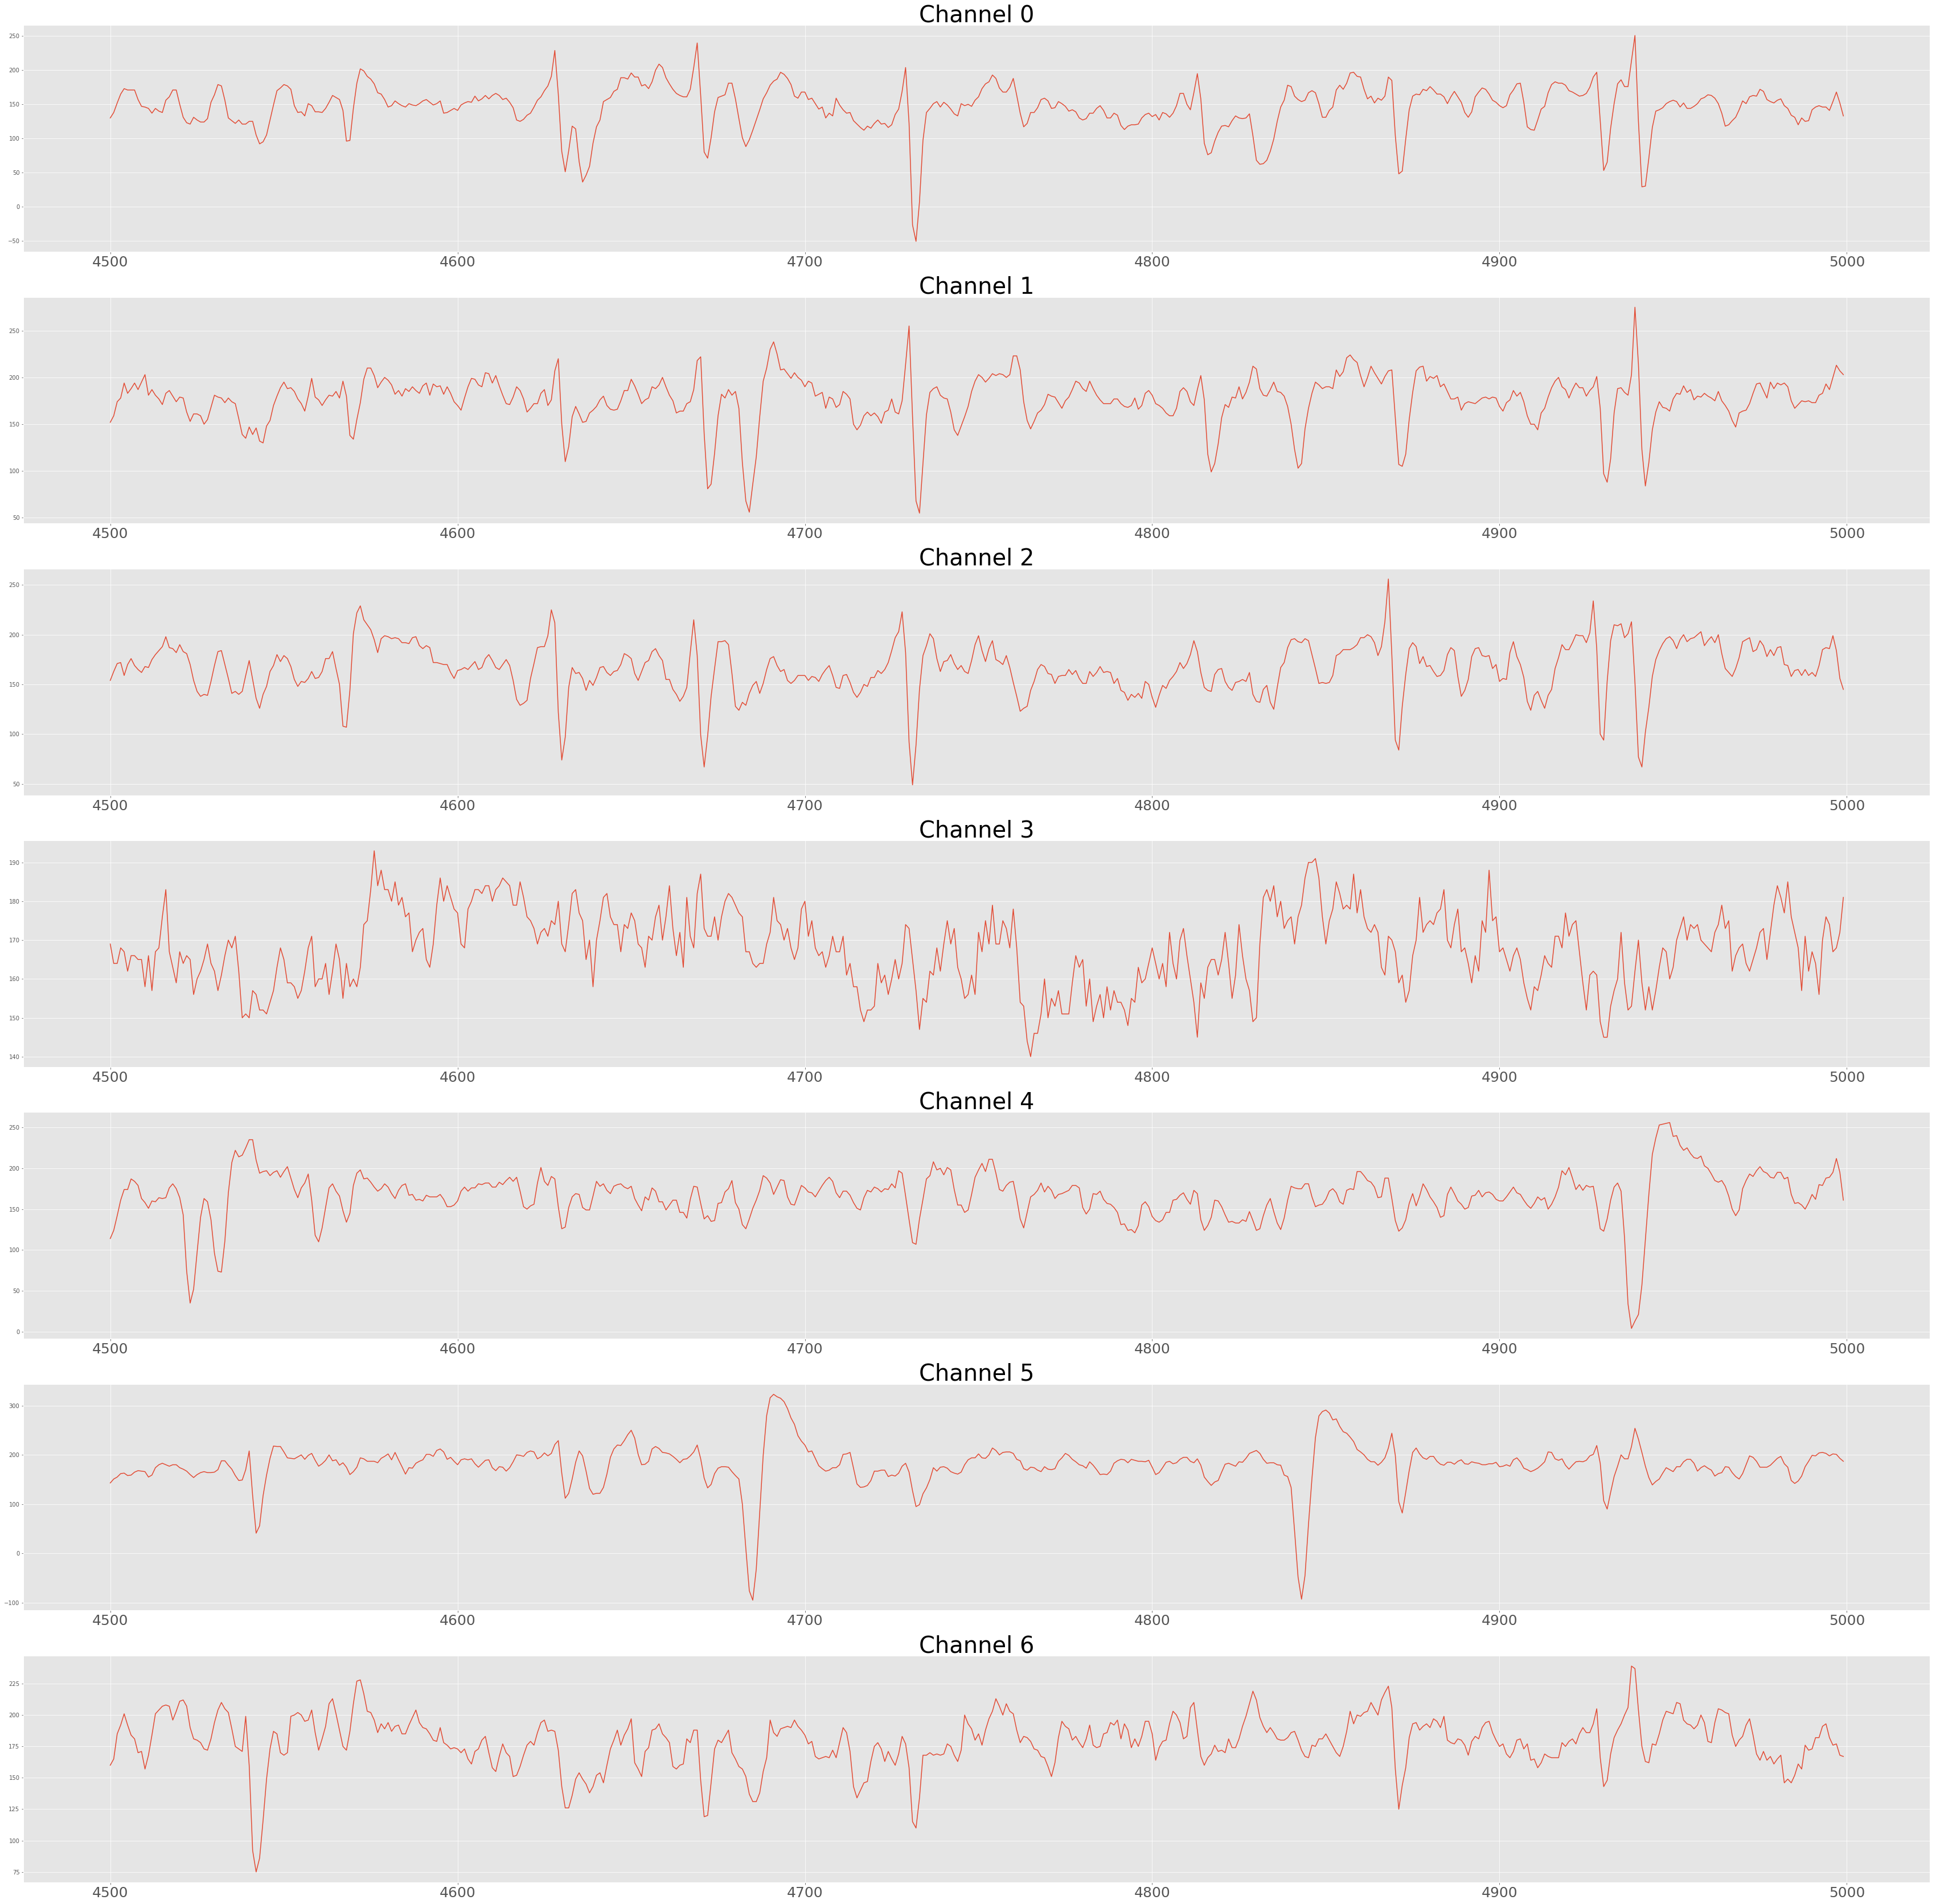

In [98]:
plt.rcParams['figure.figsize'] = (60, 60)
explorer_raw.plot_series(from_time=4500, to_time=5000)

## Filtered + Standarized Recordings

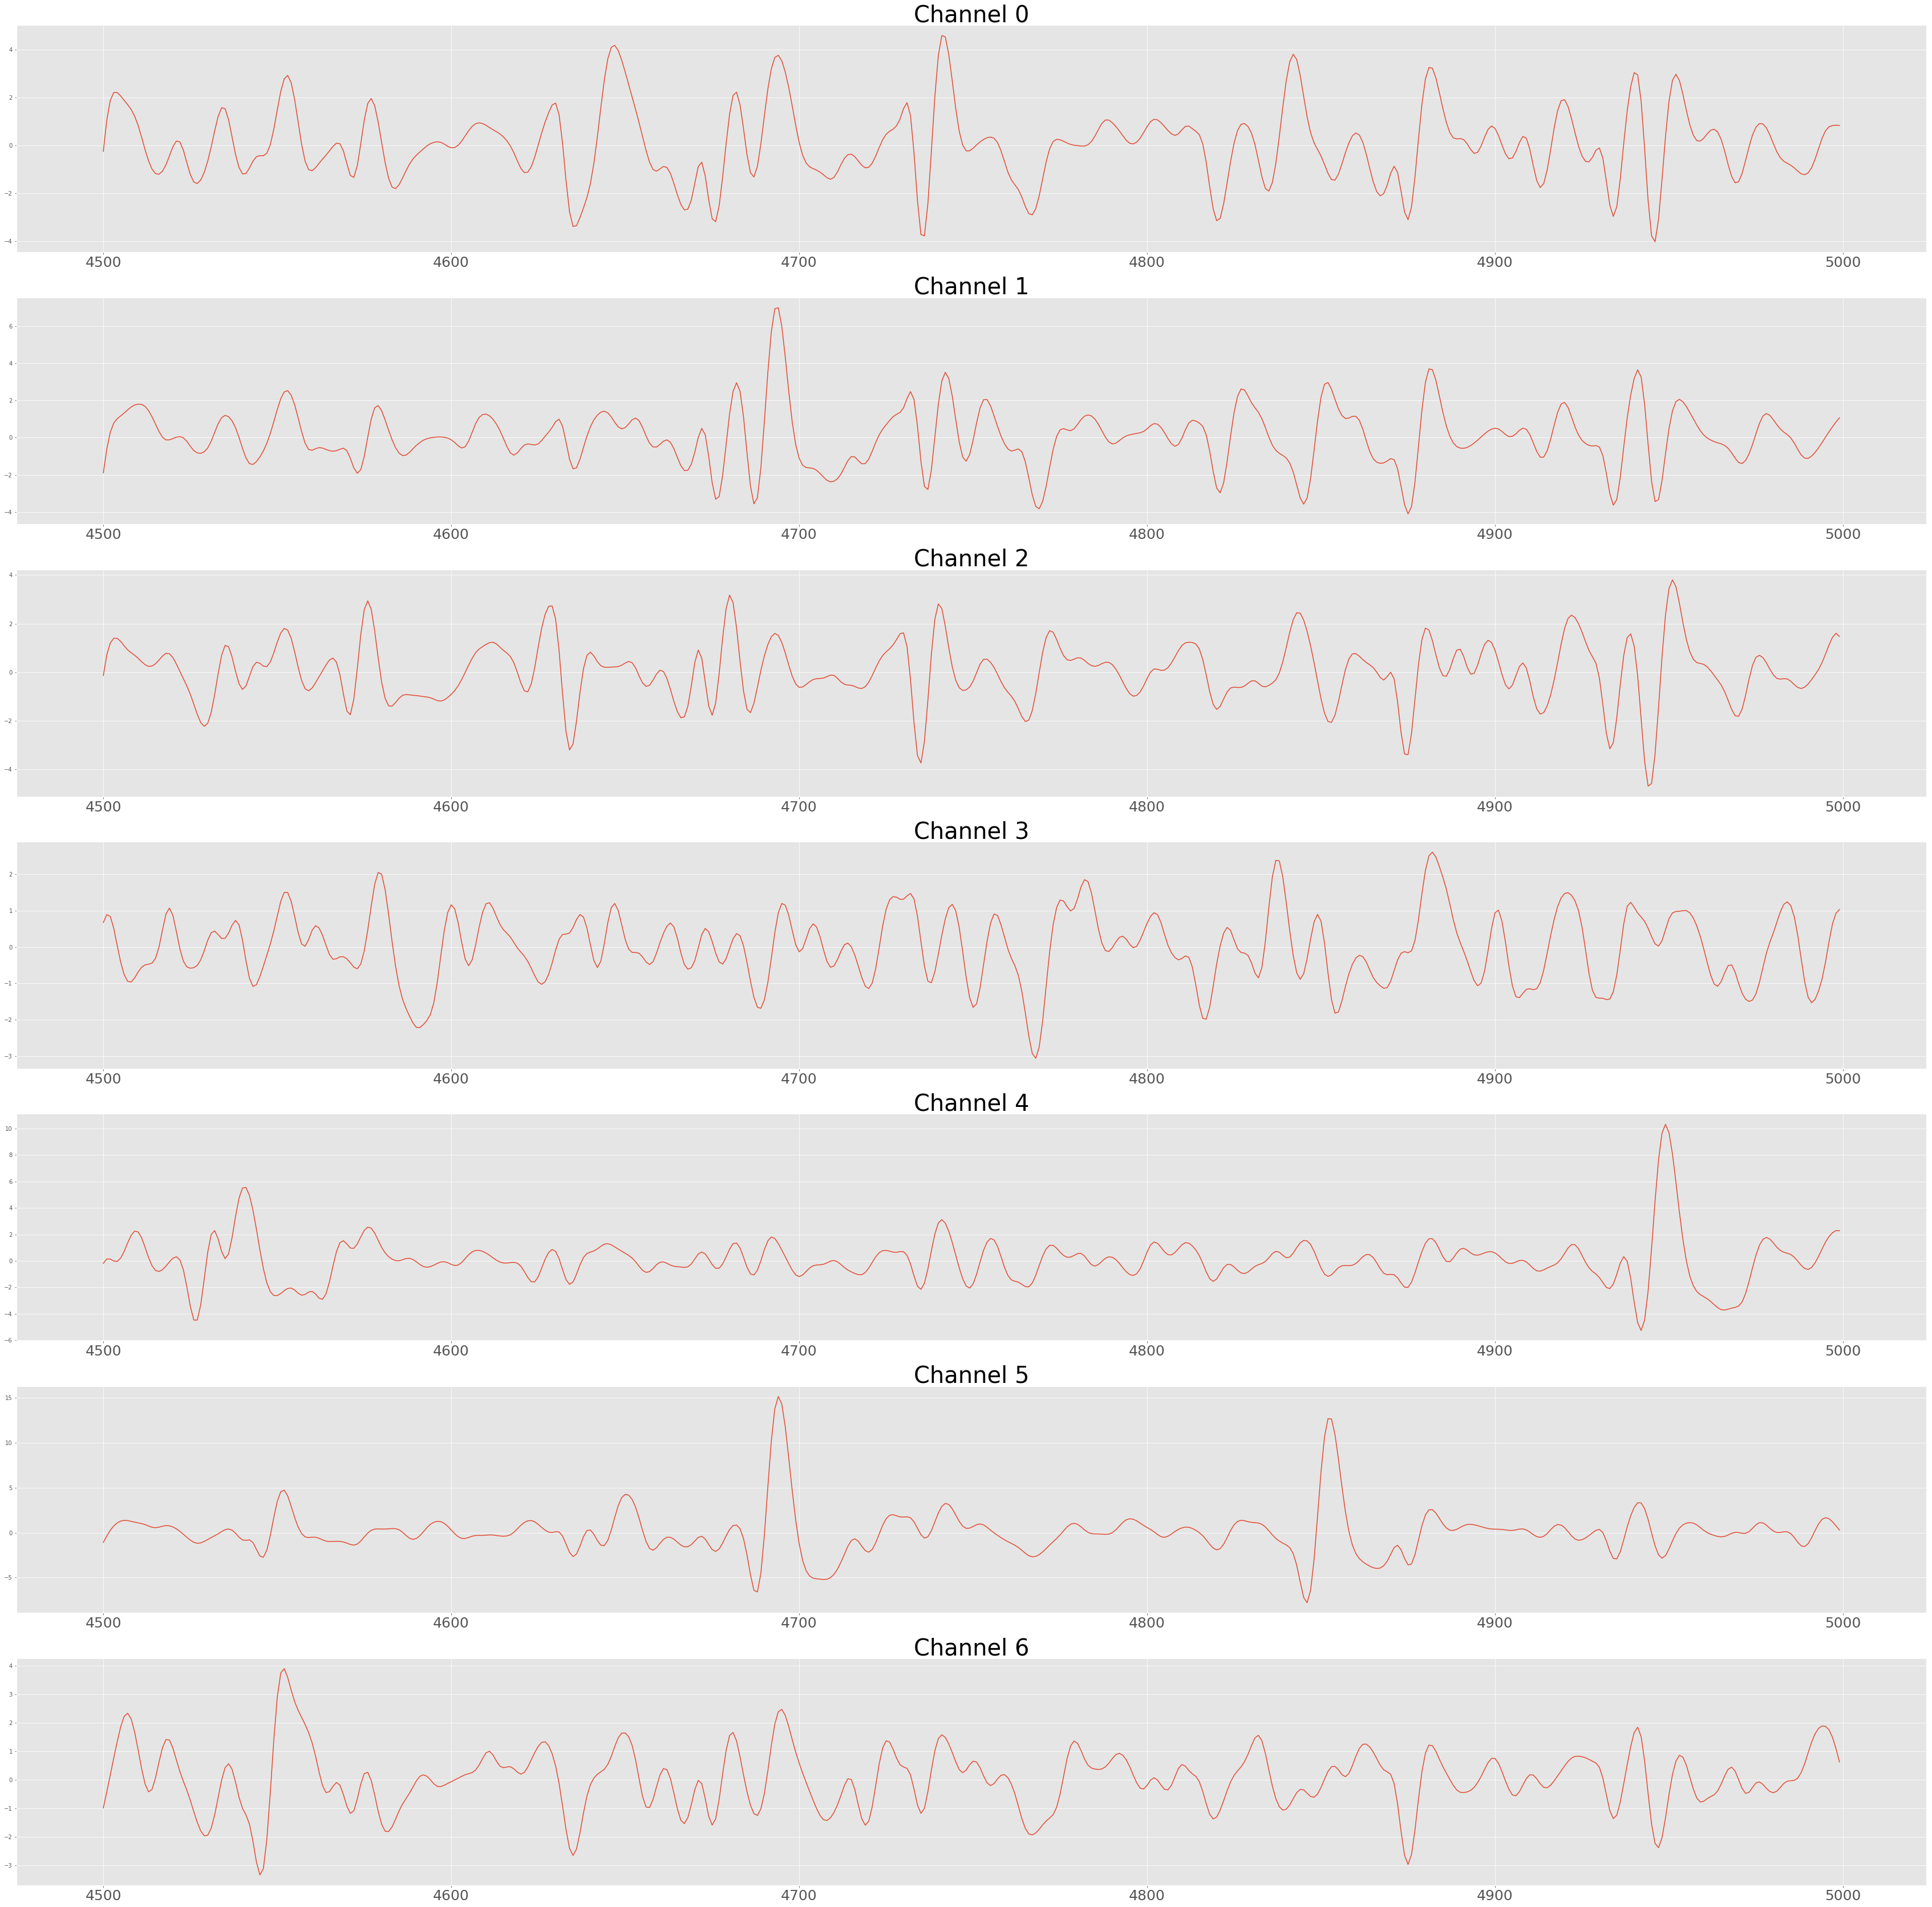

In [87]:
explorer_rec.plot_series(from_time=4500, to_time=5000)

# Geometry plot

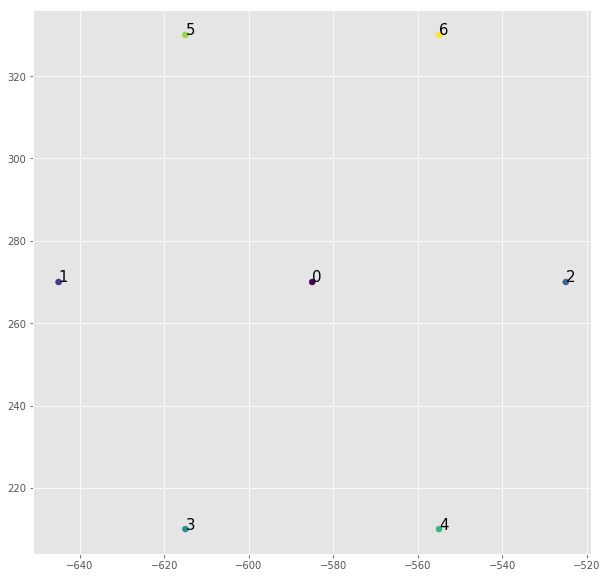

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)
explorer_rec.plot_geometry()

# Training data

## Load clear spike times in channel 0

In [82]:
clear_indexes = clear_index[0]
clear_spikes = spike_times[0][clear_indexes, 0]

In [83]:
clear_index[0]

array([ 15,  24,  29,  31,  39,  64, 104, 105, 110, 111, 119, 123, 144,
       158, 163, 175, 177, 182, 222, 252, 265, 290, 305, 307])

In [99]:
spike_times[0][15, :]

array([4807,    0], dtype=int32)

In [85]:
clear_spikes

array([ 4807,  6952,  8223,  8613, 10252, 19168, 29427, 30398, 32021,
       32455, 35270, 35903, 43239, 47187, 49517, 51600, 52038, 53203,
       68579, 79311, 83827, 93829, 99261, 99509], dtype=int32)

In [44]:
all_spike_times = np.vstack(spike_times)[:, 0]
print('{} detected spikes'.format(clear_spikes.shape[0]))

24 detected spikes


In [12]:
# there are some errors here.... check
# all_spike_times = np.sort(all_spike_times)[:-6]

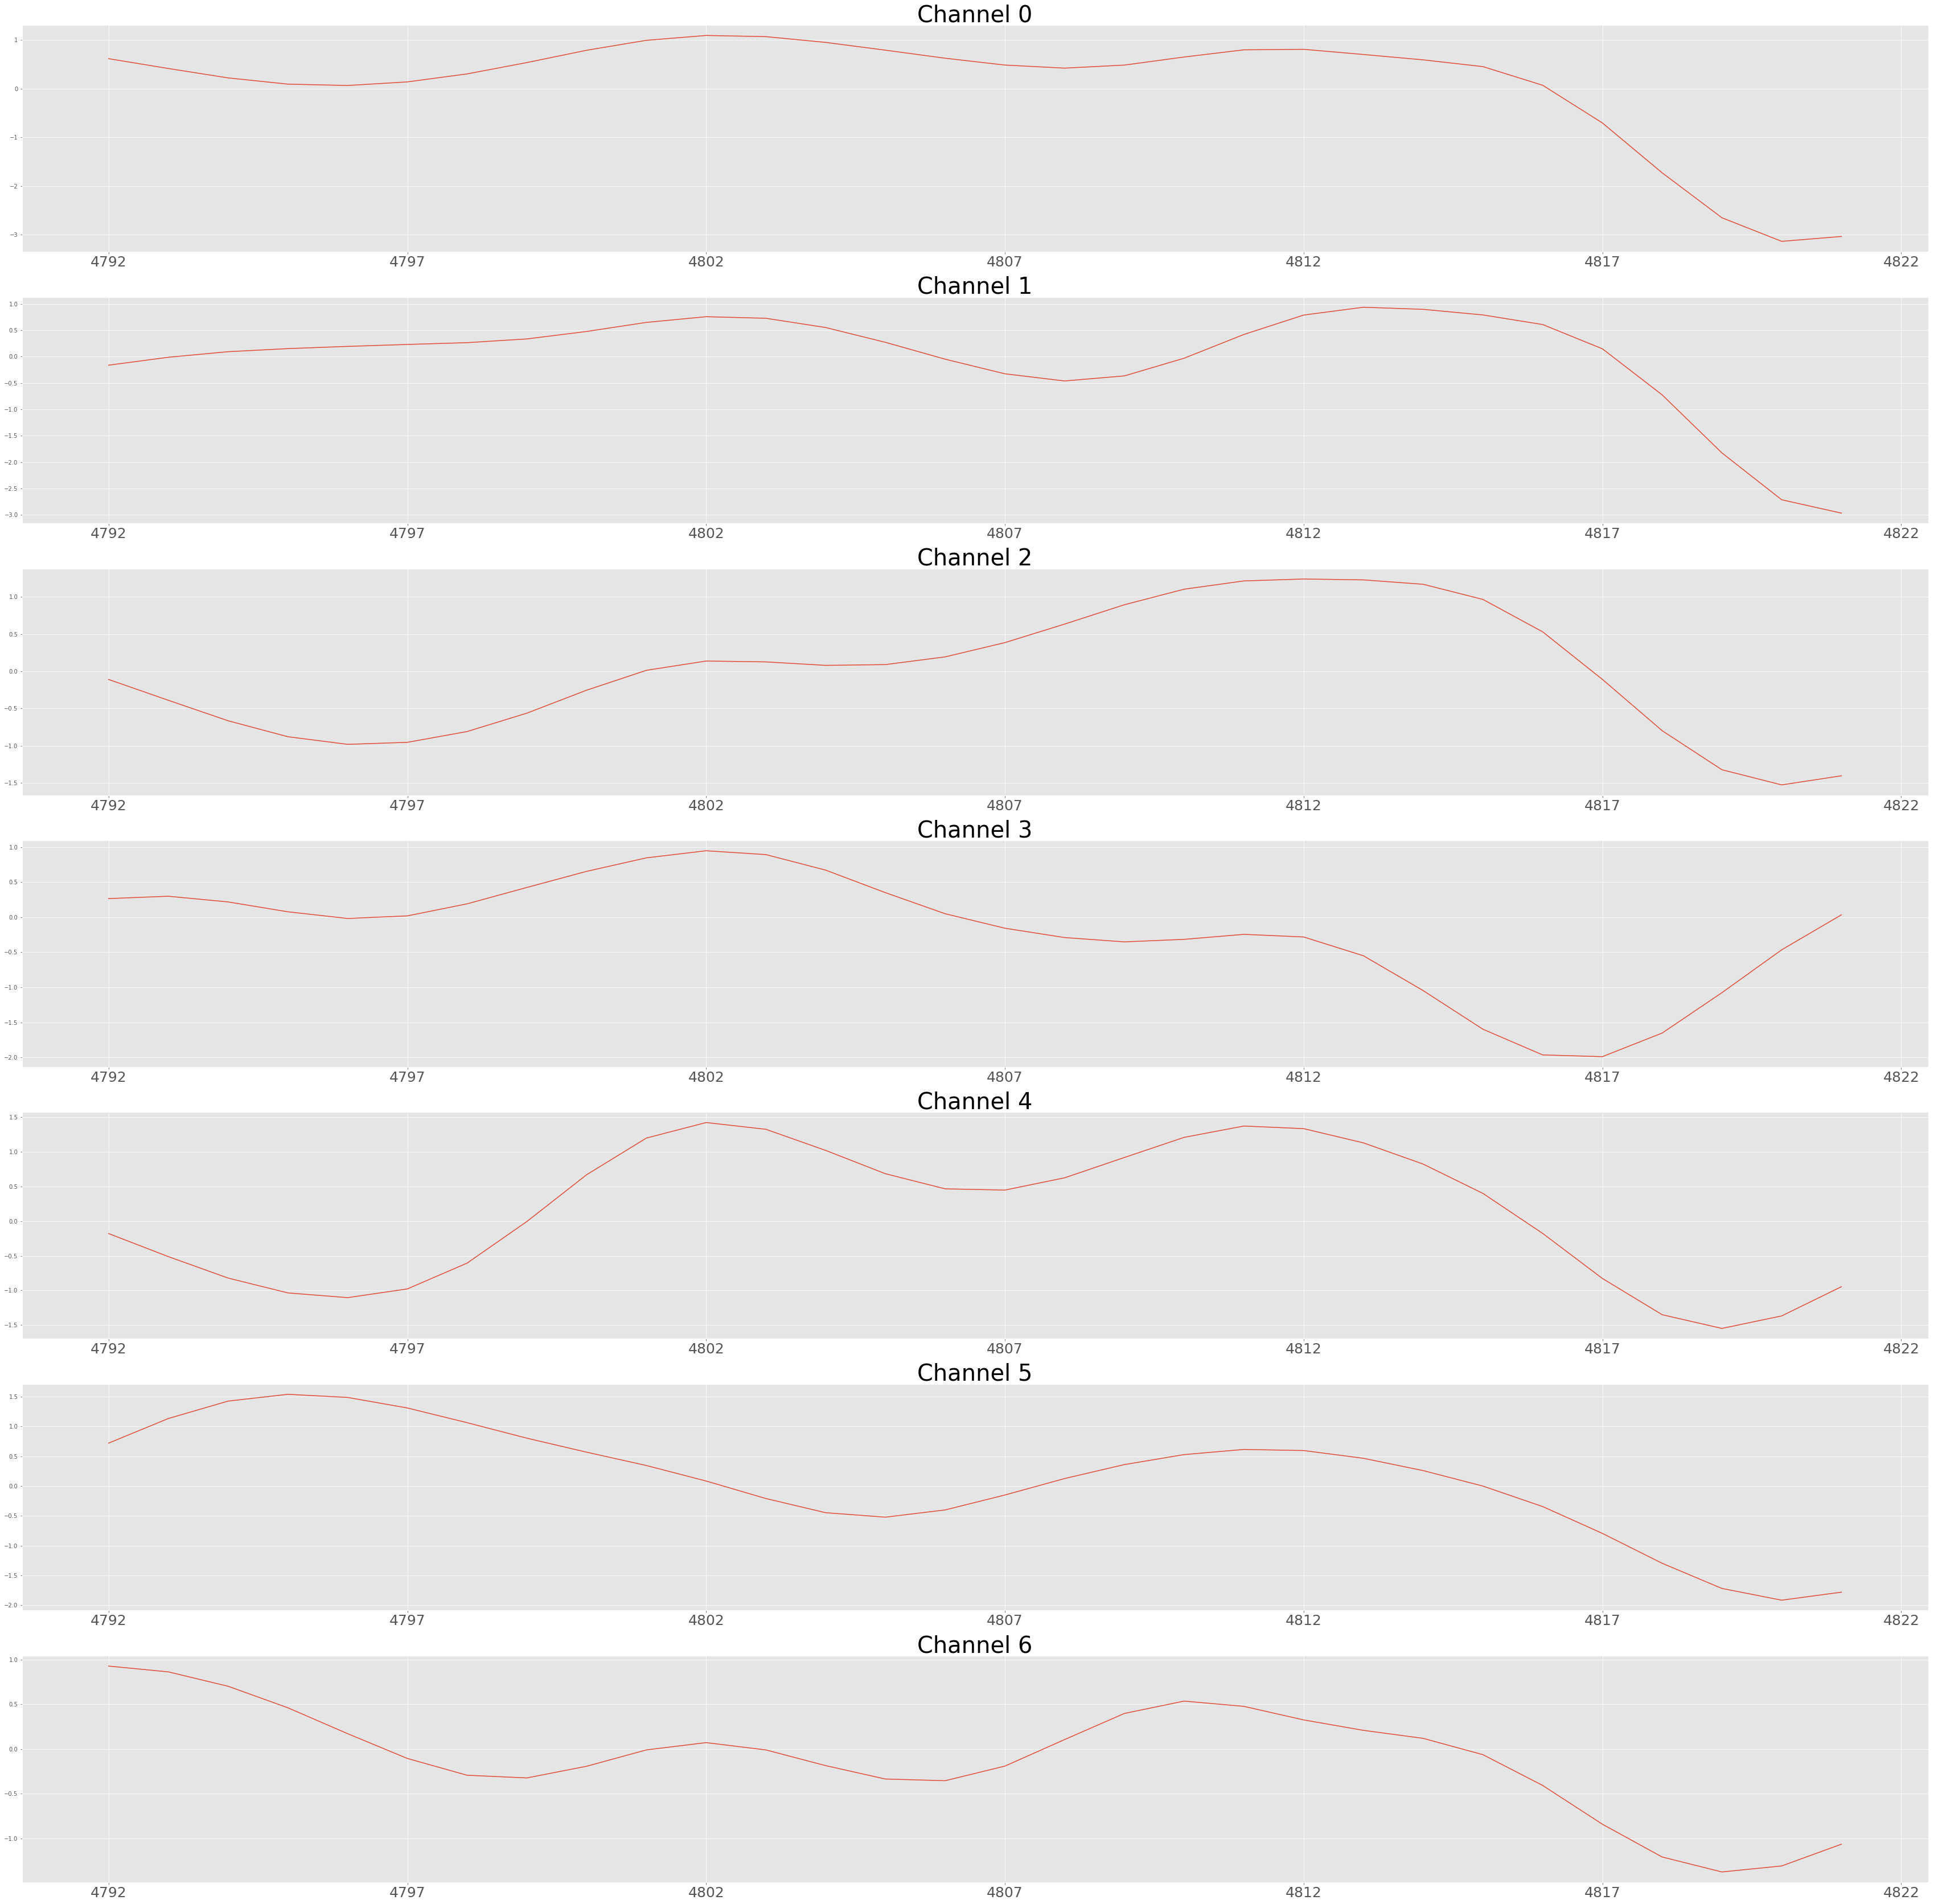

In [100]:
explorer_rec.plot_series(from_time=4807-15, to_time=4807+15)

# See how a spike looks like

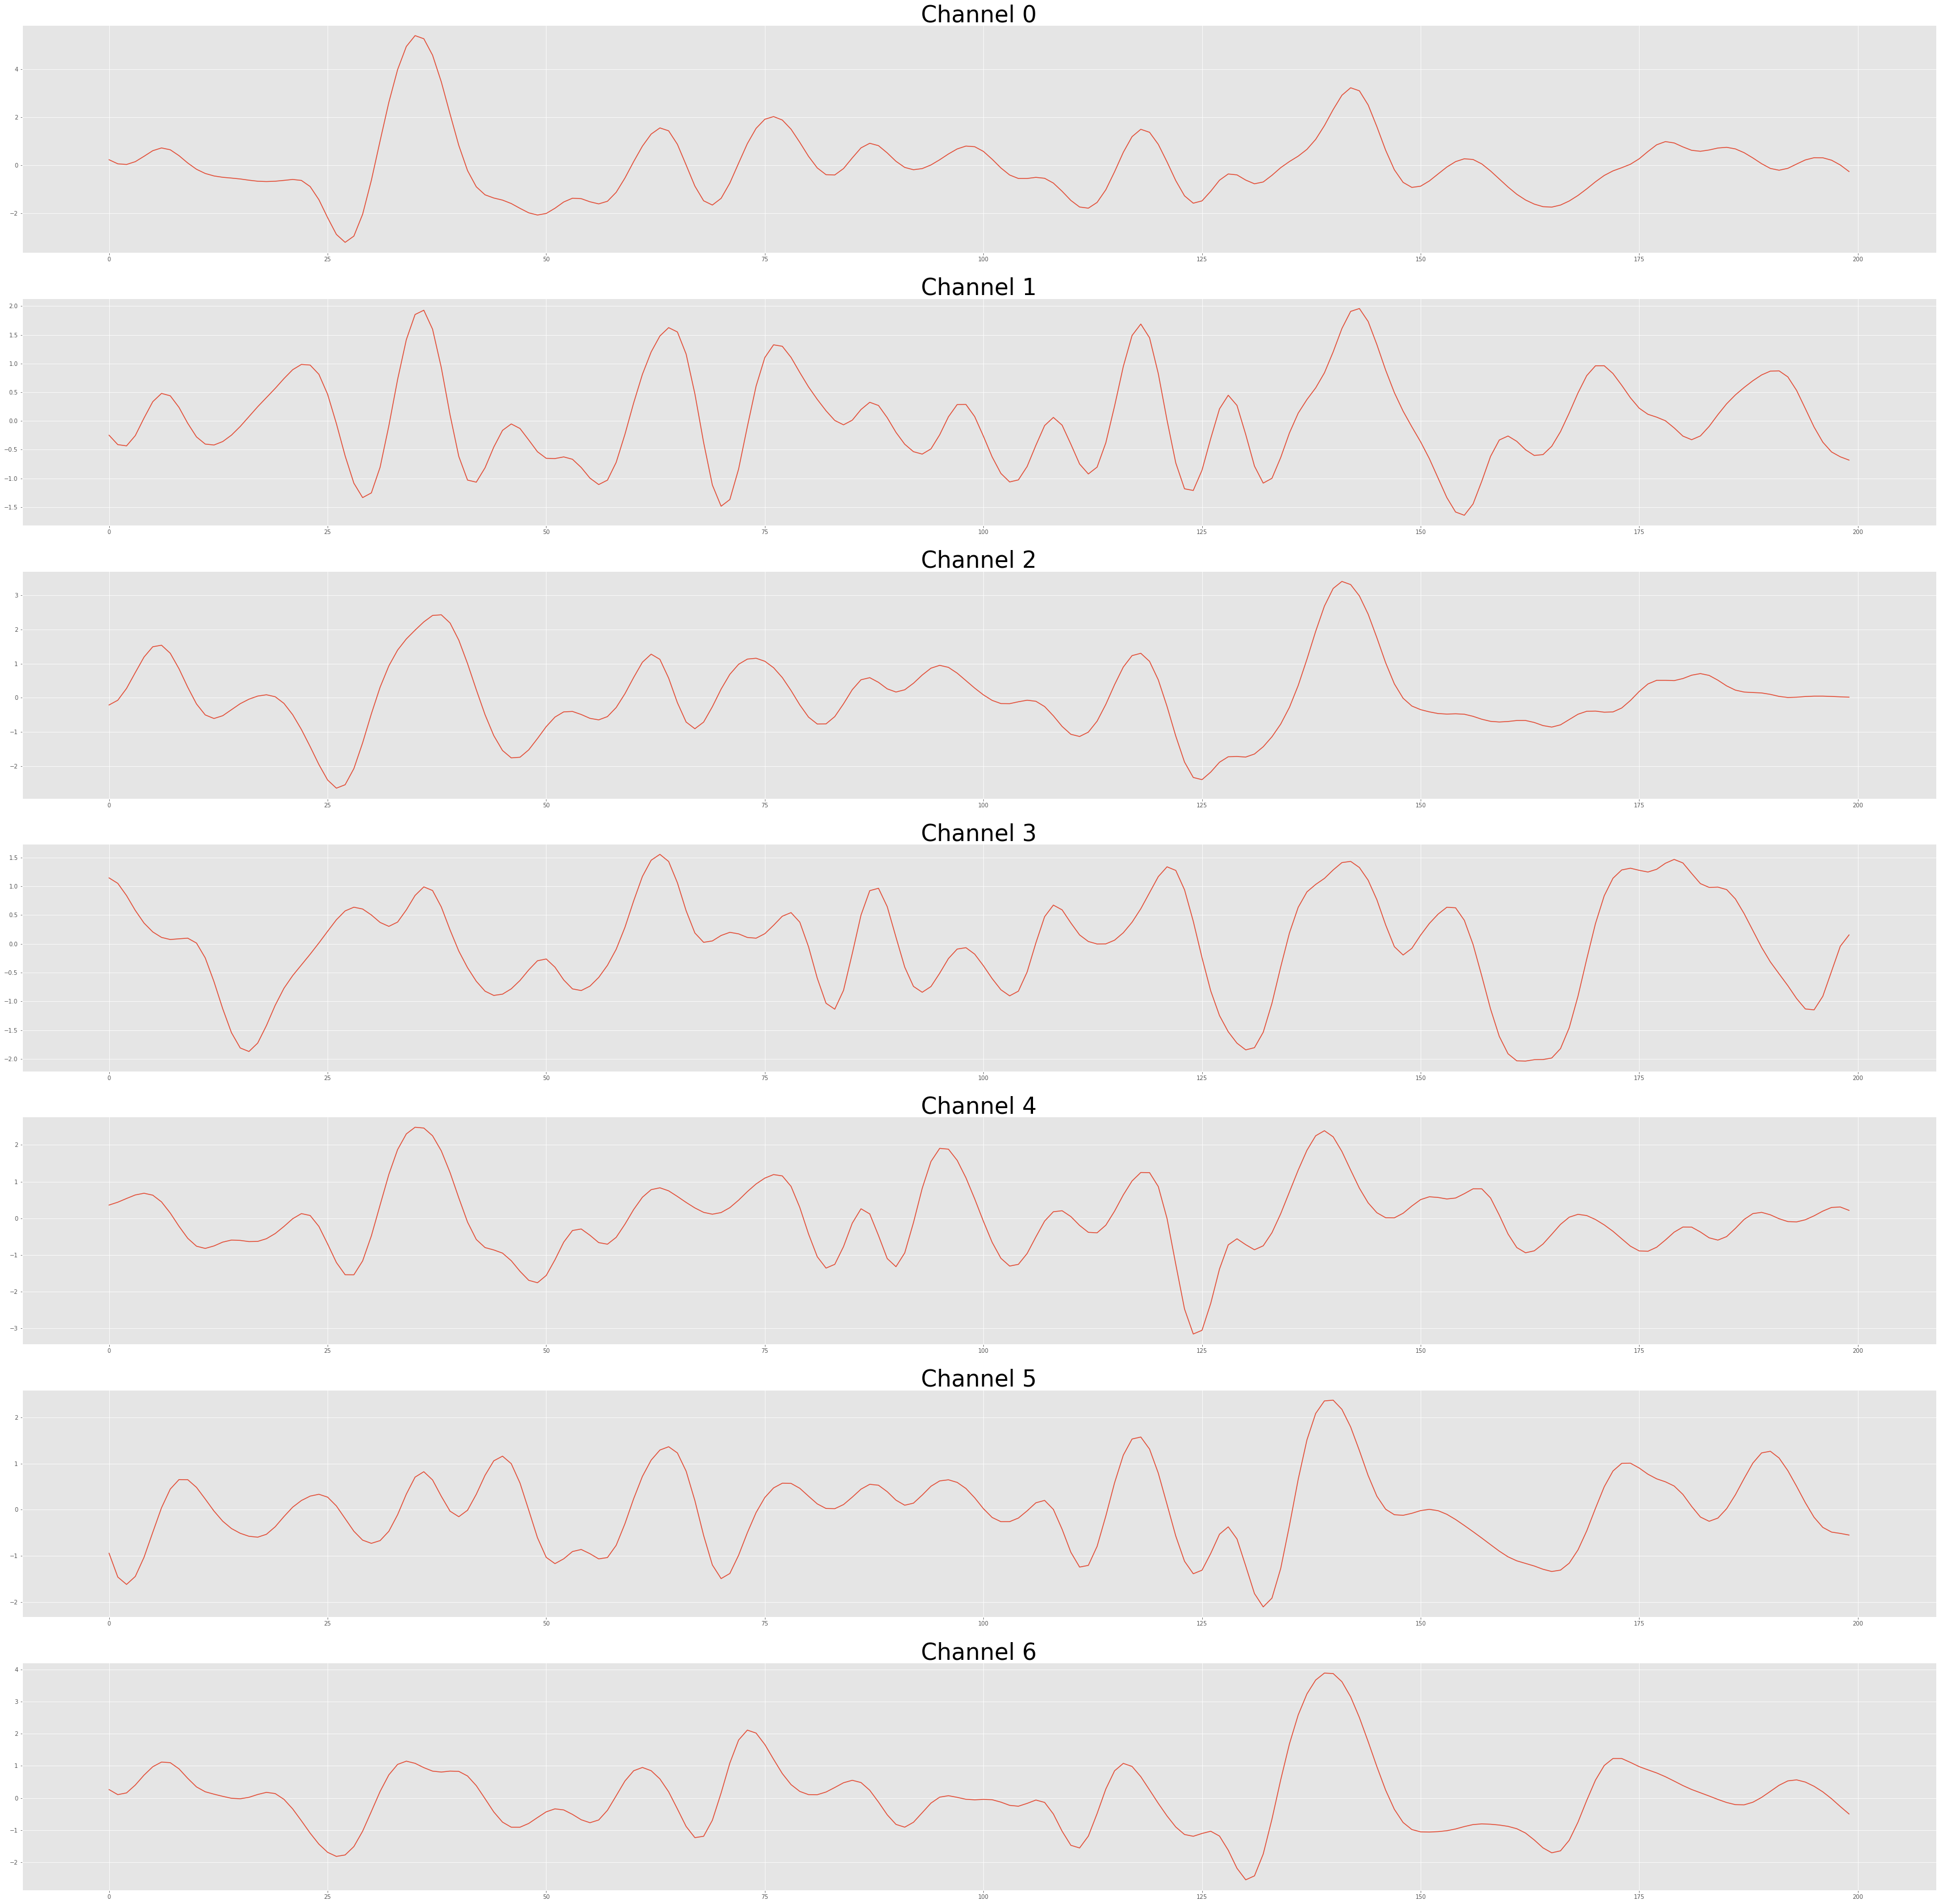

In [64]:
plt.rcParams['figure.figsize'] = (60, 60)
t = clear_spikes[20, 0]
explorer_rec.plot_series(from_time=t-100, to_time=t+100)

## Load waveforms around spike times

In [13]:
waveforms = explorer_rec.read_waveforms(times=all_spike_times)
print('Training set dimensions: {}'.format(waveforms.shape))

Training set dimensions: (6770, 31, 7)


## Reduce waveforms temporal dimensionality from 31 to 3 and flatten data

In [14]:
waveforms_reduced = explorer_train._reduce_dimension(waveforms, flatten=True)
print('Training set dimensions: {}'.format(waveforms_reduced.shape))

Training set dimensions: (6770, 21)


# Save training data

In [15]:
output_path = os.path.join(cfg['root'], 'training')
np.save(output_path, waveforms_reduced)